In [1]:
#挂载Google云盘
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# import my py file
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/nlp-beginner/task3')

# 参数设置

In [21]:
# 参数字典，方便修改
args = {
    'vocab_size': 430861,  # 有多少词，embedding需要以此来生成词向量
    'embedding_size': 50,  # 使用了glove 50d
    'hidden_size': 50,
    'type_num': 4,  # 分类个数
    'batch_size': 1000,
    'dropout': 0.1,
    'learning_rate':1e-4,
    'epoch_num': 30
}

# 数据处理

读入数据集

    直接使用数据集划分好的训练/测试集，没有重新划分

In [22]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nlp-beginner/data/snli_1.0/snli_1.0/snli_1.0_train.txt", sep="\t")
df.head(3)

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN


In [23]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nlp-beginner/data/snli_1.0/snli_1.0/snli_1.0_train.txt", sep="\t",usecols=['sentence1','sentence2','gold_label'])
df_train.head()

,gold_label,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present


In [24]:
df_train.isnull().values.any()

True

In [25]:
# 有空值（？？？）处理一下
df_train.dropna(inplace=True)

In [26]:
premise_train, hyposis_train, label_train = df_train["sentence1"].values, df_train["sentence2"].values,df_train["gold_label"]

In [27]:
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nlp-beginner/data/snli_1.0/snli_1.0/snli_1.0_test.txt", sep="\t",usecols=['sentence1','sentence2','gold_label'])
df_train.dropna()
premise_test, hyposis_test, label_test = df_test["sentence1"].values, df_test["sentence2"].values, df_test["gold_label"]

print('train data size:',len(label_train))
print('test data size:',len(label_test))

train data size: 550146
test data size: 10000


导入 [Glove](https://nlp.stanford.edu/projects/glove/)

In [28]:
with open('/content/drive/MyDrive/Colab Notebooks/nlp-beginner/data/glove.6B.50d.txt','rb') as f:  # for glove embedding
    lines=f.readlines()

In [29]:
glove_dict = {}
for line in lines:
    line = line.split()
    word = line[0].decode("utf-8").lower()
    word_vec = line[1:]
    glove_dict[word] =  list(map(float,word_vec))
print(len(glove_dict))

400000


构造词表和映射序列（参看task2

    根据评论区提醒修改了一下词典构造策略，尽可能保留更多单词增强泛化能力

In [30]:
from dataprocessing import Data_init,dataloader

sentences = list(premise_train)+list(hyposis_train)+list(premise_test)+list(hyposis_test)
data_init = Data_init(sentences,trained_dict=glove_dict,dict_size=50)
args['vocab_size'] = data_init.get_vocab_size()
glove_embed = data_init.get_embed_mat()

print('vocab_size',args['vocab_size'])

vocab_size 430861


In [31]:
label_to_index = {
    '-': 0,
    'contradiction': 1,
    'neutral': 2,
    'entailment': 3
}

In [32]:
# 序列化数据
premise_train_seq = data_init.get_id_seg(premise_train)
hyposis_train_seq = data_init.get_id_seg(hyposis_train)

premise_test_seq = data_init.get_id_seg(premise_test)
hyposis_test_seq = data_init.get_id_seg(hyposis_test)

train_y = [label_to_index[label] for label in label_train]  # Relation in training set
test_y = [label_to_index[label] for label in label_test]  # Relation in test set

train_dataloader = dataloader(premise_train_seq,hyposis_train_seq,train_y, batch_size=args['batch_size'])
test_dataloader = dataloader(premise_test_seq,hyposis_test_seq,test_y,batch_size=args['batch_size'])

# 导入模型、训练

In [33]:
import torch
import torch.nn as nn
from torch import optim

from model import ESIM

In [35]:
epoch_num = args['epoch_num']
learning_rate = args['learning_rate']

model = ESIM(vocab_size=args['vocab_size'],
        embedding_size=args['embedding_size'],
        hidden_size=args['hidden_size'],
        type_num=args['type_num'],
        dropout= args['dropout'],
        weight = torch.Tensor(glove_embed))
loss_function = nn.CrossEntropyLoss() #注：CrossEntropyLoss()自带softmax操作，在模型里不需要经过softmax层！
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#record
train_loss_history = []
test_loss_history = []
#accurancy
train_acc_history = []
test_acc_history = []

In [36]:
import random

random.seed(6)

print('train start!')
for epoch in range(epoch_num):
        #train
        model.train()
        for step,batch in enumerate(train_dataloader):
            premise,hyposis,target = batch
            target = target.cuda()
            probs = model(premise, hyposis).cuda()
            optimizer.zero_grad() #梯度初始化
            loss = loss_function(probs,target).cuda()
            loss.backward()
            optimizer.step()

        # evaluate
        model.eval()
        with torch.no_grad():
            train_accs = list()
            test_accs = list()
            train_loss = 0
            test_loss = 0

            for i, batch in enumerate(train_dataloader):
                x1, x2, y = batch
                y = y.cuda()
                pred = model(x1, x2).cuda()
                loss = loss_function(pred, y).cuda()
                train_loss += loss.item()
                _, y_pre = torch.max(pred, -1)
                acc = torch.mean((torch.tensor(y_pre == y, dtype=torch.float)))
                train_accs.append(acc)

            train_loss = train_loss / len(train_accs)
            train_acc = sum(train_accs) / len(train_accs)

            for i, batch in enumerate(test_dataloader):
                x1, x2, y = batch
                y=y.cuda()
                pred = model(x1, x2).cuda()
                loss = loss_function(pred, y).cuda()
                test_loss += loss.item()
                _, y_pre = torch.max(pred, -1)
                acc = torch.mean((torch.tensor(y_pre == y, dtype=torch.float)))
                test_accs.append(acc)

            test_loss = test_loss/ len(test_accs)
            test_acc = sum(test_accs) / len(test_accs)

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc.cpu())
            test_loss_history.append(test_loss)
            test_acc_history.append(test_acc.cpu())

        print("------------epoch:{}-------------".format(epoch+1))
        print("LOSS:train_loss:{},test_loss:{}".format(train_loss,test_loss))
        print("ACC:train_acc:{},test_acc:{}".format(train_acc,test_acc))


train start!


<ipython-input-36-de1b3672eb5c>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.mean((torch.tensor(y_pre == y, dtype=torch.float)))
<ipython-input-36-de1b3672eb5c>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.mean((torch.tensor(y_pre == y, dtype=torch.float)))


------------epoch:1-------------
LOSS:train_loss:0.9812443847006017,test_loss:1.0583220720291138
ACC:train_acc:0.5284183621406555,test_acc:0.5213000178337097
------------epoch:2-------------
LOSS:train_loss:0.8924494636058807,test_loss:0.9711155951023102
ACC:train_acc:0.5937502980232239,test_acc:0.5833000540733337
------------epoch:3-------------
LOSS:train_loss:0.8298749667947942,test_loss:0.9126329958438874
ACC:train_acc:0.632970929145813,test_acc:0.6219000220298767
------------epoch:4-------------
LOSS:train_loss:0.7889290617812763,test_loss:0.8759815871715546
ACC:train_acc:0.6580510139465332,test_acc:0.6481000185012817
------------epoch:5-------------
LOSS:train_loss:0.7631867802143097,test_loss:0.858991676568985
ACC:train_acc:0.6723781824111938,test_acc:0.661300003528595
------------epoch:6-------------
LOSS:train_loss:0.7412708666107871,test_loss:0.8441703617572784
ACC:train_acc:0.6844437122344971,test_acc:0.6669999957084656
------------epoch:7-------------
LOSS:train_loss:0.7257

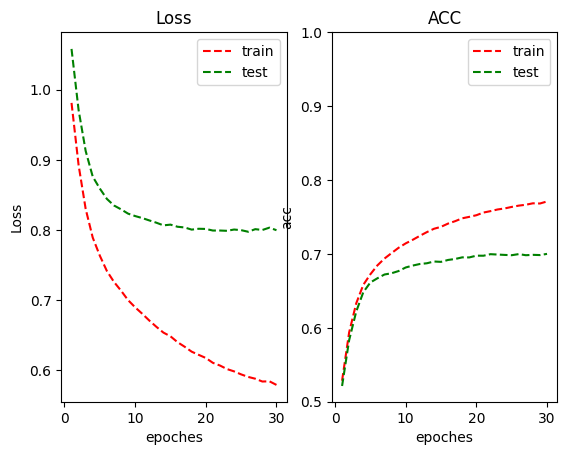

In [37]:
import matplotlib.pyplot as plt

x = list(range(1, epoch_num + 1))
plt.subplot(1, 2, 1)
plt.plot(x, train_loss_history, 'r--', label='train')
plt.plot(x, test_loss_history, 'g--', label='test')
plt.legend(fontsize=10)
plt.title("Loss")
plt.xlabel("epoches")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(x, train_acc_history, 'r--', label='train')
plt.plot(x, test_acc_history, 'g--', label='test')
plt.legend(fontsize=10)
plt.title("ACC")
plt.xlabel("epoches")
plt.ylabel("acc")
plt.ylim(0.5, 1)

plt.show()

- 效果不好……代码应该没什么问题……不知道怎么调参o(╥﹏╥)o